In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from upsetplot import generate_counts, plot, UpSet
from protlearn.features import aaindex1
from protlearn.preprocessing import remove_unnatural
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
import copy


def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and sequence in a column 'sequence'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None)
    fasta_df[['Accession', 'Sequence']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)
    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'C')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    fasta_df = fasta_df[fasta_df.Sequence != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        print("{} sequences were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df


# https://stackoverflow.com/a/50690729
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

### Feature extraction for PPI analysis

#### Get protein sequences for PPI databases

In [4]:
d = pd.read_pickle('db.pkl.gz')
set_d = set(('_'.join(d.Pairs)).split('_'))
dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03', ]

seqs = []
for i in glob('../../ref/uniprot/*'):
    seq = fasta_reader(i)
    seq['Accession'] = seq.Accession.str.split('|').apply(lambda x: x[1] if len(x)>1 else np.nan)
    seq = pd.merge(seq.dropna(), pd.DataFrame(set_d).rename(columns={0:'Accession'}), on='Accession')
    seqs.append(seq)

seq = pd.concat(seqs).drop_duplicates()
seq = seq[(~seq.Sequence.str.contains('X')) & (seq['Sequence'].str.isalpha())]
seq['Sequence_'] = seq.Sequence.apply(lambda x: len(remove_unnatural(x)))
seq = seq[seq.Sequence_==1].drop('Sequence_', axis=1)
seq['Header'] = '>' + seq.Accession
seq[['Header','Sequence']].to_csv('dbs.fasta', header=None, index=None, sep='\n')
seq = seq.drop('Header', axis=1)

12338 sequences were removed due to inconsistencies inprovided file.
13 sequences were removed due to inconsistencies inprovided file.
124 sequences were removed due to inconsistencies inprovided file.


#### Compute AAindex

In [2]:
# seq = fasta_reader('dbs.fasta')
aaind, inds = aaindex1(seq.Sequence.tolist())
seq['aaind'] = list(aaind)

dbs = []
for i in dbls:
    dd = d[d[i]==True][['Pairs']]
    dd['ProteinA'] = dd.Pairs.str.split('_').apply(lambda x: x[0])
    dd['ProteinB'] = dd.Pairs.str.split('_').apply(lambda x: x[1])    

    h = pd.merge(pd.merge(dd, seq.rename(columns={'Accession':'ProteinA'}), on='ProteinA'),\
                  seq.rename(columns={'Accession':'ProteinB'}), on='ProteinB')
    h['aaind'] = list(np.mean([h.aaind_x.tolist(), h.aaind_y.tolist()], axis=0))
    h['Label'] = 1
    h['DB'] = i
    h = h.drop_duplicates('Pairs')[['Pairs','Label','aaind','DB']]
    dbs.append(h)
dbs = pd.concat(dbs)
dbs.to_pickle('dbs.pkl.gz')

### Bootstrap replicates

#### sample PPIs

In [2]:
seq = fasta_reader('dbs.fasta')
d = pd.read_pickle('db.pkl.gz')
dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03', ]

for i in dbls:
    dd = d[d[i]==True][['Pairs']]
    dd['ProteinA'] = dd.Pairs.str.split('_').apply(lambda x: x[0])
    dd['ProteinB'] = dd.Pairs.str.split('_').apply(lambda x: x[1])
    dd = pd.merge(pd.merge(dd, seq.rename(columns={'Accession':'ProteinA'}), on='ProteinA'), seq.rename(columns={'Accession':'ProteinB'}), on='ProteinB')
    for j in range(20):
        fname = '../dscript/parallel_run/' + str(j) + '_' + i.replace(' ','_') + '.tsv'
        dd[['ProteinA','ProteinB']].sample(n=1000, random_state=j).to_csv(fname, sep='\t', header=None, index=None)
        
# BioPlex Negatives       
df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
dn = df_int[df_int.Interaction==0].copy()

for j in range(100):
    fname = '../dscript/parallel_run/' + str(j) + '_bioplex_neg.tsv'
    dn['Pairs'] = dn[['UniprotA','UniprotB']].sample(n=1000, random_state=j).to_csv(fname, sep='\t', header=None, index=None)

#### Run D-SCRIPT

````
cd ../dscript/parallel_run/
ls *.tsv | parallel -j 10 "dscript predict --pairs {} --model ../../src/dscript/dscript-data/models/human_v1.sav --seqs ../jupyter/dbs.fasta -o {}.dscript_out"
````

#### Parse D-SCRIPT output files

In [3]:
p = pd.DataFrame(glob('../dscript/parallel_run/*.dscript_out.tsv'))
p['Sample'] = p[0].str.split('/').apply(lambda x: x[-1])\
.str.split('_').apply(lambda x: x[0])
p['DB'] = p[0].str.split('/').apply(lambda x: x[-1])\
.str.split('_').apply(lambda x: x[1] + '_' + x[2])\
.str.replace('.tsv.dscript','', regex=True)
p['Size'] = p[0].apply(lambda x: os.path.getsize(x))
p = p[p.Size!=0]
pos = p[p.DB!='bioplex_neg']
neg = p[p.DB=='bioplex_neg']

dfpos = []
for i in pos.DB.value_counts().index:
    for j in pos[pos.DB==i][0].tolist():
        df = pd.read_csv(j, sep='\t', header=None)
        df['DB'] = i
        df['Label'] = 1
        dfpos.append(df)
dfpos = pd.concat(dfpos)

dfneg = []
for i in neg[0].tolist():
    df = pd.read_csv(i, sep='\t', header=None)
    df['DB'] = 'BioPlex Negatives'
    df['Label'] = 0
    dfneg.append(df)
dfneg = pd.concat(dfneg)

df = pd.concat([dfpos,dfneg]).drop_duplicates()
df.columns = ['ProteinA','ProteinB','D-SCRIPT Probabiliy','DB','Label']
df['Pairs'] = df[['ProteinA', 'ProteinB']].values.tolist()
df['Pairs'] = df.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df = df.drop_duplicates('Pairs')
df['DB'] = df.DB.str.replace('_',' ')
df.to_pickle('dbs_boostrap.pkl.gz')
df.DB.value_counts()

BioPlex Negatives    87634
MINT 2021-12-19      10015
IntAct 2021-10-13     9344
DIP 20170205          9241
mentha 2021-12-20     9152
BioPlex 3.0           6965
STRING 11.5           6578
BIOGRID 4.4.204       3577
signor 2022-01-03     2333
Name: DB, dtype: int64

#### Compute D-SCRIPT performance metrices

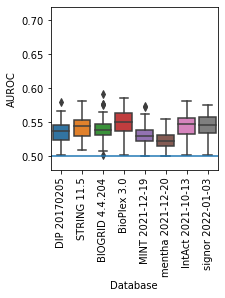

In [4]:
df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
df_int['Pairs'] = df_int[['UniprotA','UniprotB']].values.tolist()
df_int['Pairs'] = df_int.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df_int = df_int.drop_duplicates('Pairs')

ns = list(set(('_'.join(df_int[df_int.Interaction==0].Pairs)).split('_')))
neg_train, neg_test = train_test_split(ns, test_size=0.5, random_state=42)
neg_train = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_train).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_train).rename(columns={0:'ProteinB'}), on='ProteinB')
neg_test = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_test).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_test).rename(columns={0:'ProteinB'}), on='ProteinB')


dscript = []
for i in dbls:
    for j in range(100):
        pos = df[df.DB==i].sample(n=500, random_state=j)
        neg = neg_test.sample(n=5000, random_state=j)
        f = pd.concat([pos, neg])
        dscript.append([i, roc_auc_score(f.Label.tolist(), f['D-SCRIPT Probabiliy'].tolist()), \
    average_precision_score(f.Label.tolist(), f['D-SCRIPT Probabiliy'].tolist())])
    
dscript = pd.DataFrame(dscript)
dscript.columns = ['Database','AUROC','AUPRC']
dscript = dscript.set_index('Database').loc[dbls].reset_index()
dscript['AUROC'] = dscript.AUROC.apply(lambda x: 1-x if x<0.5 else x)

plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUROC', data=dscript)
g.axhline(0.5)
plt.xticks(rotation=90)
plt.ylim(0.48, 0.72)
plt.savefig('../../fig/dscript_aurocs.pdf')

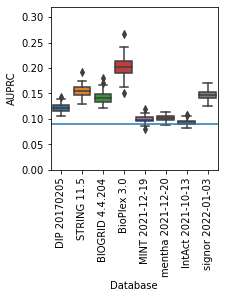

In [5]:
plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUPRC', data=dscript)
g.axhline(500/5500)
plt.xticks(rotation=90)
plt.ylim(0, 0.32)
plt.savefig('../../fig/dscript_auprcs.pdf')

#### Evaluate random forest classifier trained on human PPIs in STRING

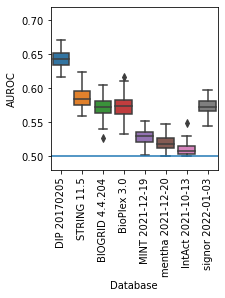

In [6]:
clf = pd.read_pickle('../../clf/string_human_clf.pickle')

dbs = pd.read_pickle('dbs.pkl.gz')
dnts = pd.merge(df_int, neg_test[['Pairs']], on='Pairs')
dnts['Label'] = 0
dnts['DB'] = 'BioPlex Negatives'
dnts = dnts[['Pairs', 'Label', 'aaind', 'DB']]
dt = pd.concat([dnts,dbs])

fs = []
perfs = []

for j,k in enumerate(dbls):
    for l in range(100):
        pos = dt[dt.DB==k].sample(n=500, random_state=l)
        neg = dt[dt.DB=='BioPlex Negatives'].sample(n=5000, random_state=l)
        f = pd.concat([pos, neg])
        f['Bootstrap'] = l
        f['Probability'] = clf.predict_proba(f.aaind.values.tolist())[:,1]
        f['Interaction types'] = 'Generic'
        fs.append(f)
        perf = [k,
            roc_auc_score(f.Label.tolist(), f.Probability.tolist()), \
            average_precision_score(f.Label.tolist(), f.Probability.tolist())]
        perfs.append(perf)

fs = pd.concat(fs)
fs.drop('aaind', axis=1).to_pickle('string_human_clf_fs.pkl.gz')
perfs = pd.DataFrame(perfs)
perfs.columns = ['Database','AUROC','AUPRC']
perfs.to_pickle('string_human_clf_perfs.pkl.gz')

# perfs = pd.read_pickle('string_human_clf_perfs.pkl.gz')
# dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03']
# perfs = perfs.set_index('Database').loc[dbls].reset_index()
perfs['AUROC'] = perfs.AUROC.apply(lambda x: 1-x if x<0.5 else x)

plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUROC', data=perfs)
g.axhline(0.5)
plt.xticks(rotation=90)
plt.ylim(0.48, 0.72)
plt.savefig('../../fig/string_human_clf_aurocs.pdf')

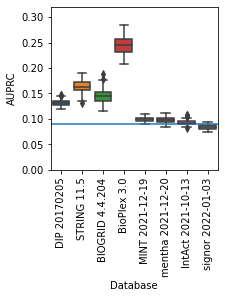

In [7]:
# perfs = pd.read_pickle('string_human_clf_perfs.pkl.gz')

plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUPRC', data=perfs)
g.axhline(500/5500)
plt.xticks(rotation=90)
plt.ylim(0, 0.32)
plt.savefig('../../fig/string_human_clf_auprcs.pdf')

### Built interaction type-specific classifiers

#### STRING protein.actions

In [2]:
act = pd.read_csv('../../ref/string/9606.protein.actions.v10.5.txt.gz', sep='\t')
act['STRING'] = act[['item_id_a','item_id_b']].values.tolist()
act['STRING'] = act.STRING.apply(lambda x: '_'.join(sorted(x)))

string = pd.read_pickle('string.pkl.gz')
act = pd.merge(string, act, on='STRING')

dbs = pd.read_pickle('dbs.pkl.gz')
act = pd.merge(dbs[dbs.DB=='STRING 11.5'], act, on='Pairs').drop_duplicates(['Pairs','STRING'])
act.to_pickle('string_act.pkl.gz')

In [6]:
dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03', ]

dbs = pd.read_pickle('dbs.pkl.gz')
dp = pd.read_pickle('string_act.pkl.gz').drop_duplicates('STRING', keep=False)
df = pd.read_pickle('dbs_boostrap.pkl.gz')

df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
df_int['Pairs'] = df_int[['UniprotA','UniprotB']].values.tolist()
df_int['Pairs'] = df_int.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df_int = df_int.drop_duplicates('Pairs')

ns = list(set(('_'.join(df_int[df_int.Interaction==0].Pairs)).split('_')))
neg_train, neg_test = train_test_split(ns, test_size=0.5, random_state=42)
neg_train = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_train).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_train).rename(columns={0:'ProteinB'}), on='ProteinB')
neg_test = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_test).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_test).rename(columns={0:'ProteinB'}), on='ProteinB')



dntr = pd.merge(df_int, neg_train[['Pairs']], on='Pairs')
dntr['Label'] = 0
dntr['DB'] = 'BioPlex Negatives'
dntr = dntr[['Pairs', 'Label', 'aaind', 'DB']]
full = pd.concat([dntr,dbs])
rp = pd.concat([dbs.drop_duplicates(['Pairs','DB'])[['Pairs']], dntr[['Pairs']]]).drop_duplicates(keep=False)
sn = pd.merge(rp, full, on='Pairs')

dnts = pd.merge(df_int, neg_test[['Pairs']], on='Pairs')
dnts['Label'] = 0
dnts['DB'] = 'BioPlex Negatives'
dnts = dnts[['Pairs', 'Label', 'aaind', 'DB']]
dt = pd.concat([dnts,dbs])

In [7]:
dp = pd.read_pickle('string_act.pkl.gz').drop_duplicates('STRING', keep=False)
mode = list(dp['mode'].unique())

size = []
clfs = []
for i,v in enumerate(mode):
    size.append([v, len(dp[dp['mode']==v]), len(sn[sn.Label==0])])
    dd = pd.concat([dp[dp['mode']==v], sn[sn.Label==0]]).sample(frac=1,random_state=12345)
    clf = RandomForestClassifier(random_state=12345) #, n_jobs=-1)
    clf.fit(dd.aaind.tolist(), dd.Label.tolist()) #.set_params(n_jobs=1)
    clfs.append(clf)
with open('../../clf/string_mode_clfs.pickle', 'wb') as handle:
    pickle.dump(clfs, handle)

size = pd.DataFrame(size) #.sort_values([1], ascending=False)
size

0      1      2
0     binding  15925  21912
1       ptmod    926  21912
2  activation   1283  21912
3    reaction   7295  21912
4  inhibition    542  21912
5   catalysis   3525  21912
6  expression    265  21912

In [8]:
# clfs = pd.read_pickle('../../clf/string_mode_clfs.pickle')

fs = []
perfs = []
for i,v in enumerate(mode):
    for j,k in enumerate(dbls):
        for l in range(100):
            pos = dt[dt.DB==k].sample(n=500, random_state=l)
            neg = dt[dt.DB=='BioPlex Negatives'].sample(n=5000, random_state=l)
            f = pd.concat([pos, neg])
            f['Bootstrap'] = l
            f['Probability'] = clfs[i].predict_proba(f.aaind.values.tolist())[:,1]
            f['Interaction types'] = v
            fs.append(f)
            perf = [v, k,
                roc_auc_score(f.Label.tolist(), f.Probability.tolist()), \
                average_precision_score(f.Label.tolist(), f.Probability.tolist()), \
                len(pos), len(neg)]
            perfs.append(perf)

fs = pd.concat(fs)
fs.drop('aaind', axis=1).to_pickle('string_mode_clfs_fs.pkl.gz')
perfs = pd.DataFrame(perfs)
perfs.columns = ['Interaction types','Database','AUROC','AUPRC','Positives','Negatives']

# dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03']
# perfs = perfs.set_index('Database').loc[dbls].reset_index()
perfs['AUROC'] = perfs.AUROC.apply(lambda x: 1-x if x<0.5 else x)
perfs.to_pickle('string_mode_clfs_perfs.pkl.gz')

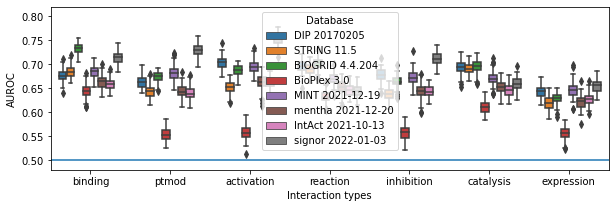

In [7]:
perfs = pd.read_pickle('string_mode_clfs_perfs.pkl.gz')

plt.figure(figsize=(10,3))
g = sns.boxplot(x='Interaction types', y='AUROC', hue='Database', data=perfs)#[perfs!='signor 2022-01-03'])
g.axhline(0.5)
# plt.xticks(rotation=90)
plt.ylim(0.48, 0.82)
plt.savefig('../../fig/string_mode_clfs_aurocs.pdf')

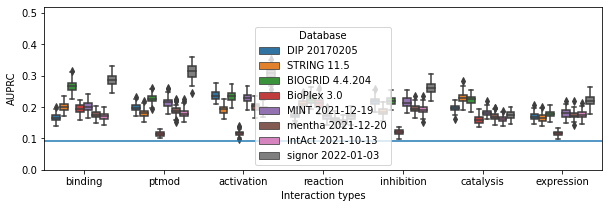

In [8]:
plt.figure(figsize=(10,3))
g = sns.boxplot(x='Interaction types', y='AUPRC', hue='Database', data=perfs)#[perfs!='signor 2022-01-03'])
g.axhline(500/5500)
# plt.xticks(rotation=90)
plt.ylim(0, 0.52)
plt.savefig('../../fig/string_mode_clfs_auprcs.pdf')

#### signor interaction types

In [6]:
# train on signor and test on other databases
signor = pd.read_csv('../../ref/signor/Jan2022_release.txt.gz', sep='\t')
signor = signor[(signor.DATABASEA=='UNIPROT') & (signor.DATABASEB=='UNIPROT')].copy()
signor['Pairs'] = signor[['IDA','IDB']].values.tolist()
signor['Pairs'] = signor.Pairs.apply(lambda x: '_'.join(sorted(x)))

dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03', ]
dbs = pd.read_pickle('dbs.pkl.gz')

df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
df_int['Pairs'] = df_int[['UniprotA','UniprotB']].values.tolist()
df_int['Pairs'] = df_int.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df_int = df_int.drop_duplicates('Pairs')

ns = list(set(('_'.join(df_int[df_int.Interaction==0].Pairs)).split('_')))
neg_train, neg_test = train_test_split(ns, test_size=0.5, random_state=42)
neg_train = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_train).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_train).rename(columns={0:'ProteinB'}), on='ProteinB')
neg_test = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_test).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_test).rename(columns={0:'ProteinB'}), on='ProteinB')

dntr = pd.merge(df_int, neg_train[['Pairs']], on='Pairs')
dntr['Label'] = 0
dntr['DB'] = 'BioPlex Negatives'
dntr = dntr[['Pairs', 'Label', 'aaind', 'DB']]

# test set
dnts = pd.merge(df_int, neg_test[['Pairs']], on='Pairs')
dnts['Label'] = 0
dnts['DB'] = 'BioPlex Negatives'
dnts = dnts[['Pairs', 'Label', 'aaind', 'DB']]
dt = pd.concat([dnts,dbs])

full = pd.concat([dntr,dbs])
rp = pd.concat([dbs.drop_duplicates(['Pairs','DB'])[['Pairs']], dntr[['Pairs']]]).drop_duplicates(keep=False)
sn = pd.merge(rp, full, on='Pairs')


dp = []
for i in signor.value_counts('MECHANISM').head(10).index:
    pp = pd.merge(sn, signor[signor.MECHANISM==i][['Pairs']], on='Pairs')
    pp['MECHANISM'] = i
#     print(len(pp),i)
    dp.append(pp)   
dp = pd.concat(dp).drop_duplicates(['Pairs','MECHANISM'])

size = []
clfs = []
for i,v in enumerate(signor.value_counts('MECHANISM').head(10).index):
    size.append([v, len(dp[dp.MECHANISM==v]), len(sn[sn.Label==0])])
    dd = pd.concat([dp[dp.MECHANISM==v], sn[sn.Label==0]]).sample(frac=1,random_state=12345)
    clf = RandomForestClassifier(random_state=12345) #, n_jobs=-1)
    clf.fit(dd.aaind.tolist(), dd.Label.tolist()) #.set_params(n_jobs=1)
    clfs.append(clf)
with open('../../clf/signor_clfs.pickle', 'wb') as handle:
    pickle.dump(clfs, handle)
    
size = pd.DataFrame(size)
size #.sort_values([1], ascending=False)

0     1      2
0                     phosphorylation  2554  23462
1                             binding  2152  23462
2          transcriptional regulation  2483  23462
3                   dephosphorylation   254  23462
4                            cleavage   156  23462
5                      ubiquitination    65  23462
6                      relocalization   138  23462
7  guanine nucleotide exchange factor    27  23462
8           gtpase-activating protein    29  23462
9     post transcriptional regulation    51  23462

In [7]:
# clfs = pd.read_pickle('../../clf/signor_clfs.pickle')

fs = []
perfs = []
for i,v in enumerate(signor.value_counts('MECHANISM').head(10).index):
    for j,k in enumerate(dbls):
        for l in range(100):
            pos = dt[dt.DB==k].sample(n=500, random_state=l)
            neg = dt[dt.DB=='BioPlex Negatives'].sample(n=5000, random_state=l)
            f = pd.concat([pos, neg])
            f['Bootstrap'] = l
            f['Probability'] = clfs[i].predict_proba(f.aaind.values.tolist())[:,1]
            f['Interaction types'] = v
            fs.append(f)
            perf = [v, k,
                roc_auc_score(f.Label.tolist(), f.Probability.tolist()), \
                average_precision_score(f.Label.tolist(), f.Probability.tolist()), \
                len(pos), len(neg)]
            perfs.append(perf)

fs = pd.concat(fs)
fs.drop('aaind', axis=1).to_pickle('signor_clfs_fs.pkl.gz')
perfs = pd.DataFrame(perfs)
perfs.columns = ['Interaction types','Database','AUROC','AUPRC','Positive pairs','Negative pairs']
perfs['AUROC'] = perfs.AUROC.apply(lambda x: 1-x if x<0.5 else x)
perfs.to_pickle('signor_clfs_perfs.pkl.gz')

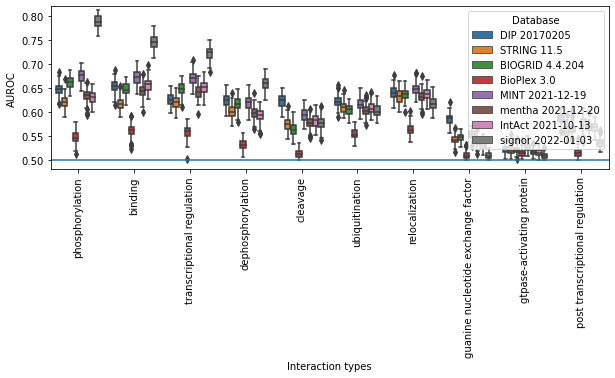

In [11]:
# perfs = pd.read_pickle('signor_clfs_perfs.pkl.gz')

plt.figure(figsize=(10,3))
g = sns.boxplot(x='Interaction types', y='AUROC', hue='Database', data=perfs)#[perfs!='signor 2022-01-03'])
g.axhline(0.5)
plt.xticks(rotation=90)
plt.ylim(0.48, 0.82)
plt.savefig('../../fig/signor_clfs_aurocs.pdf')

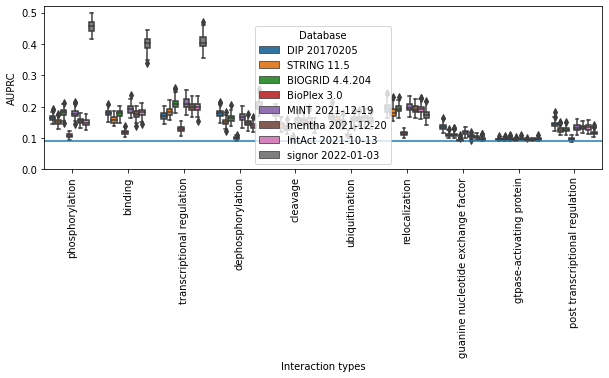

In [12]:
plt.figure(figsize=(10,3))
g = sns.boxplot(x='Interaction types', y='AUPRC', hue='Database', data=perfs)#[perfs!='signor 2022-01-03'])
g.axhline(500/5500)
plt.xticks(rotation=90)
plt.ylim(0, 0.52)
plt.savefig('../../fig/signor_clfs_auprcs.pdf')

#### Performance of max probability

In [4]:
dbls = ['DIP 20170205', 'STRING 11.5', 'BIOGRID 4.4.204', 'BioPlex 3.0', 'MINT 2021-12-19', 'mentha 2021-12-20', 'IntAct 2021-10-13','signor 2022-01-03', ]
dbs = pd.read_pickle('dbs.pkl.gz')

df_int = pd.read_pickle('bioplex_interactions_aaindex1.pkl.gz')
df_int['Pairs'] = df_int[['UniprotA','UniprotB']].values.tolist()
df_int['Pairs'] = df_int.Pairs.apply(lambda x: '_'.join(sorted([x[0], x[1]])))
df_int = df_int.drop_duplicates('Pairs')

ns = list(set(('_'.join(df_int[df_int.Interaction==0].Pairs)).split('_')))
neg_train, neg_test = train_test_split(ns, test_size=0.5, random_state=42)
neg_train = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_train).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_train).rename(columns={0:'ProteinB'}), on='ProteinB')
neg_test = pd.merge(pd.merge(df[df.DB=='BioPlex Negatives'], pd.DataFrame(neg_test).rename(columns={0:'ProteinA'}), on='ProteinA'), \
                    pd.DataFrame(neg_test).rename(columns={0:'ProteinB'}), on='ProteinB')

dntr = pd.merge(df_int, neg_train[['Pairs']], on='Pairs')
dntr['Label'] = 0
dntr['DB'] = 'BioPlex Negatives'
dntr = dntr[['Pairs', 'Label', 'aaind', 'DB']]

full = pd.concat([dntr,dbs])
rp = pd.concat([dbs.drop_duplicates(['Pairs','DB'])[['Pairs']], dntr[['Pairs']]]).drop_duplicates(keep=False)
sn = pd.merge(rp, full, on='Pairs')

In [4]:
# test set
dnts = pd.merge(df_int, neg_test[['Pairs']], on='Pairs')
dnts['Label'] = 0
dnts['DB'] = 'BioPlex Negatives'
dnts = dnts[['Pairs', 'Label', 'aaind', 'DB']]
dt = pd.concat([dnts,dbs])


clfs = []
clfs.append(pd.read_pickle('../../clf/string_human_clf.pickle'))
[clfs.append(i) for i in pd.read_pickle('../../clf/string_mode_clfs.pickle')]
[clfs.append(i) for i in pd.read_pickle('../../clf/signor_clfs.pickle')]


fs = []

for j,k in enumerate(dbls):
    for l in range(100):
        pos = dt[dt.DB==k].sample(n=500, random_state=l)
        neg = dt[dt.DB=='BioPlex Negatives'].sample(n=5000, random_state=l)
        f = pd.concat([pos, neg])
        f['Bootstrap'] = l
        f['Probability'] = np.array([i.predict_proba(f.aaind.values.tolist())[:,1] for i in clfs]).T.tolist()
        fs.append(f)
        
with open('max_fs.pickle', 'wb') as handle:
    pickle.dump(fs, handle)

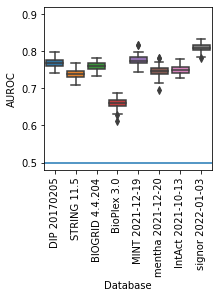

In [2]:
with open('max_fs.pickle', 'rb') as handle:
    fs = pickle.load(handle)
    
perfs = []

for l in range(len(fs)):
    perf = [fs[l].DB.unique()[0], fs[l].Bootstrap.unique()[0],
        roc_auc_score(fs[l].Label.tolist(), fs[l].Probability.apply(lambda x: np.median(x)).tolist()), \
        average_precision_score(fs[l].Label.tolist(), fs[l].Probability.apply(lambda x: np.median(x)).tolist())]
    perfs.append(perf)
        
perfs = pd.DataFrame(perfs)
perfs.columns = ['Database','Bootstrap','AUROC','AUPRC']
# perfs.to_pickle('max_perfs.pkl.gz')


plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUROC', data=perfs)
g.axhline(0.5)
plt.xticks(rotation=90)
plt.ylim(0.48, 0.92)
plt.savefig('../../fig/median_aurocs.pdf')

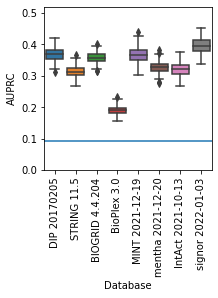

In [3]:
plt.figure(figsize=(3,3))
g = sns.boxplot(x='Database', y='AUPRC', data=perfs)
g.axhline(500/5500)
plt.xticks(rotation=90)
plt.ylim(0, 0.52)
plt.savefig('../../fig/median_auprcs.pdf')

In [6]:
fs[0][fs[0].Label==1]

Pairs  Label  \
36654  P11904_P11904      1   
27641  P06239_P08575      1   
28132  P13747_Q03519      1   
29228  P49368_Q8IWZ6      1   
16073  P38837_P42839      1   
...              ...    ...   
33974  P09373_P0ABU7      1   
19709  P33335_P34240      1   
41211  O45003_Q18043      1   
31131  Q8R4B8_Q9ES74      1   
23739  Q04439_Q08673      1   

                                                   aaind            DB  \
36654  [4.34965625, 0.87971875, 0.957625, 1.0106875, ...  DIP 20170205   
27641  [4.371492612304702, 0.8970671180617191, 0.9447...  DIP 20170205   
28132  [4.337482043096568, 0.8741037428538854, 1.0706...  DIP 20170205   
29228  [4.3343826265477645, 0.892517418361455, 0.9953...  DIP 20170205   
16073  [4.362653825484053, 0.9875329261092693, 1.1325...  DIP 20170205   
...                                                  ...           ...   
33974  [4.335706212251941, 0.8806836712683348, 1.0485...  DIP 20170205   
19709  [4.3551784138630465, 0.9432791098711597, 1.173...  DIP 20170205   
41211  [4.35990045377198, 0.9921571185479297, 0.91481...  DIP 20170205   
31131  [4.369823378188649, 0.9460322438983735, 1.0813...  DIP 20170205   
23739  [4.370353080198445, 0.7815047072151255, 0.9477...  DIP 20170205   

       Bootstrap                                        Probability  
36654          0  [0.3, 0.51, 0.1, 0.26, 0.45, 0.1, 0.33, 0.04, ...  
27641          0  [0.08, 0.55, 0.33, 0.28, 0.32, 0.25, 0.27, 0.0...  
28132          0  [0.07, 0.76, 0.01, 0.02, 0.08, 0.01, 0.01, 0.0...  
29228          0  [0.77, 0.37, 0.0, 0.62, 0.21, 0.0, 0.17, 0.0, ...  
16073          0  [0.01, 0.33, 0.05, 0.06, 0.16, 0.06, 0.06, 0.0...  
...          ...                                                ...  
33974          0  [0.29, 0.24, 0.0, 0.01, 0.14, 0.0, 0.01, 0.0, ...  
19709          0  [0.02, 0.32, 0.07, 0.13, 0.36, 0.04, 0.19, 0.1...  
41211          0  [0.03, 0.32, 0.23, 0.24, 0.4, 0.25, 0.39, 0.13...  
31131          0  [0.05, 0.55, 0.1, 0.09, 0.31, 0.03, 0.24, 0.02...  
23739          0  [0.21, 0.49, 0.38, 0.48, 0.46, 0.37, 0.45, 0.3...  

[500 rows x 6 columns]

In [2]:
with open('max_fs.pickle', 'rb') as handle:
    fs = pickle.load(handle)

dist = []

for l in range(len(fs)):
    d = fs[l][fs[l].Label==1]
    d = [d.DB.unique()[0], d.Bootstrap.unique()[0],
        d.Probability.apply(lambda x: np.median(x)).tolist()]
    dist.append(d)
    
dist = pd.DataFrame(dist)
dist['max'] = dist[2].apply(lambda x: np.max(x))
dist['median'] = dist[2].apply(lambda x: np.median(x))
dist.sort_values('max', ascending=False)

0   1                                                  2  \
286    BIOGRID 4.4.204  86  [0.02, 0.10500000000000001, 0.065, 0.005, 0.16...   
427    MINT 2021-12-19  27  [0.0, 0.155, 0.06, 0.07500000000000001, 0.025,...   
244    BIOGRID 4.4.204  44  [0.0, 0.19, 0.005, 0.05500000000000001, 0.0550...   
799  signor 2022-01-03  99  [0.01, 0.315, 0.08499999999999999, 0.015, 0.03...   
745  signor 2022-01-03  45  [0.1, 0.07, 0.03, 0.35, 0.060000000000000005, ...   
..                 ...  ..                                                ...   
308        BioPlex 3.0   8  [0.015, 0.015, 0.0, 0.01, 0.16, 0.0, 0.0, 0.02...   
396        BioPlex 3.0  96  [0.015, 0.055, 0.035, 0.07500000000000001, 0.0...   
369        BioPlex 3.0  69  [0.08, 0.065, 0.035, 0.035, 0.035, 0.02, 0.0, ...   
323        BioPlex 3.0  23  [0.025, 0.26, 0.04, 0.065, 0.0, 0.005, 0.01, 0...   
349        BioPlex 3.0  49  [0.035, 0.005, 0.045, 0.015, 0.19, 0.03, 0.005...   

       max  median  
286  0.645  0.0550  
427  0.645  0.0550  
244  0.635  0.0500  
799  0.630  0.0650  
745  0.630  0.0650  
..     ...     ...  
308  0.300  0.0250  
396  0.290  0.0300  
369  0.290  0.0300  
323  0.285  0.0275  
349  0.265  0.0300  

[800 rows x 5 columns]

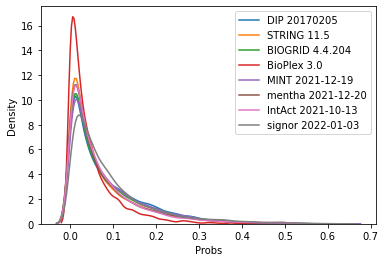

In [3]:
probs = []
for i in dist[0].unique():
    p = pd.DataFrame({'DB':i,'Probs':[item for sublist in dist[dist[0]==i][2].tolist() for item in sublist]})
    probs.append(p)
    
probs = pd.concat(probs)

for i in probs.DB.unique():
    sns.kdeplot(probs[probs.DB==i].Probs, label=i)
plt.legend()

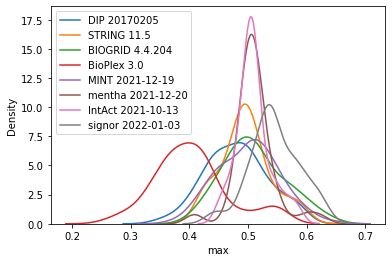

In [4]:
for i in dist[0].unique():
    sns.kdeplot(dist[dist[0]==i]['max'], label=i)
plt.legend()

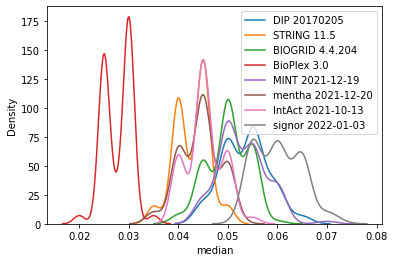

In [5]:
for i in dist[0].unique():
    sns.kdeplot(dist[dist[0]==i]['median'], label=i)
plt.legend()

#### Scatterplot matrix of feature importances

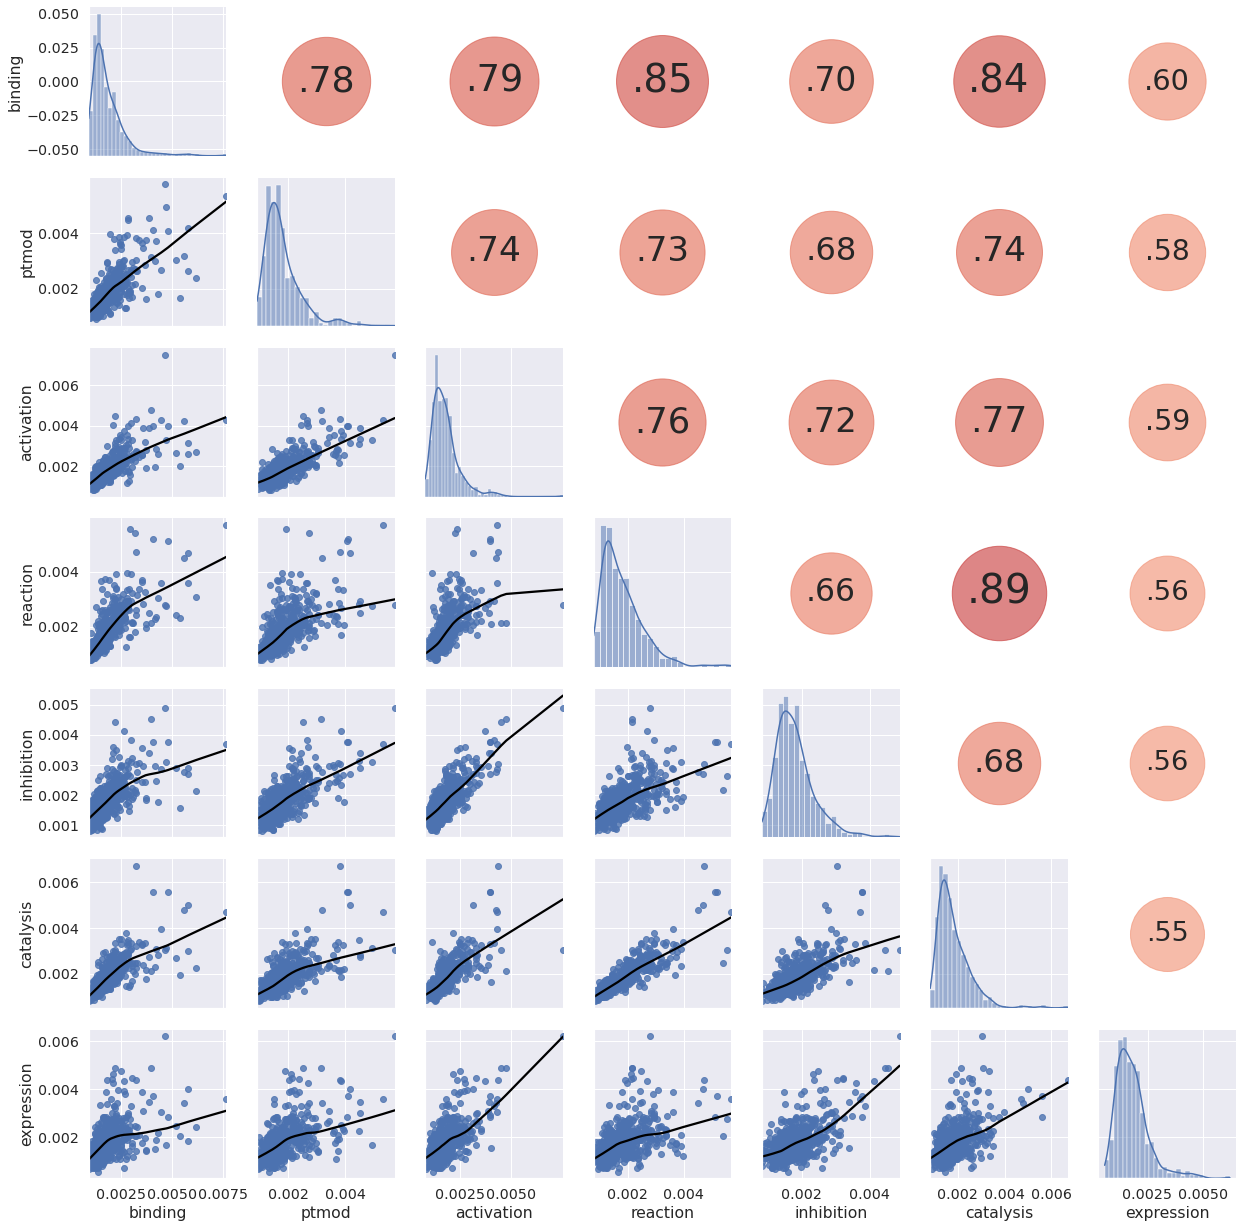

In [2]:
aai, ind = aaindex1('AGVWPY')

dp = pd.read_pickle('string_act.pkl.gz').drop_duplicates('STRING', keep=False)
mode = list(dp['mode'].unique())

clfs = pd.read_pickle('../../clf/string_mode_clfs.pickle')

gini = []
for i in clfs:    
    importances = i.feature_importances_
    std = np.std([tree.feature_importances_ for tree in i.estimators_], axis=0)
    gi = pd.DataFrame(importances, index=ind)
    gi['std'] = std
    gi.reset_index(inplace=True)
    gi.columns = ['AAindex','Gini','Stdev']
    gini.append(gi)
    
for i,v in enumerate(mode):
    gini[i]['mode'] = v

gini = pd.concat(gini)
ginit = gini.pivot(index='mode', columns='AAindex', values='Gini').T
ginit = ginit[mode]


sns.set(font_scale=1.3) #style='white', 
g = sns.PairGrid(ginit, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde=True)
g.map_upper(corrdot)
plt.savefig('../../fig/string_mode_clfs_corrmatrix.pdf')

#### signor interaction types

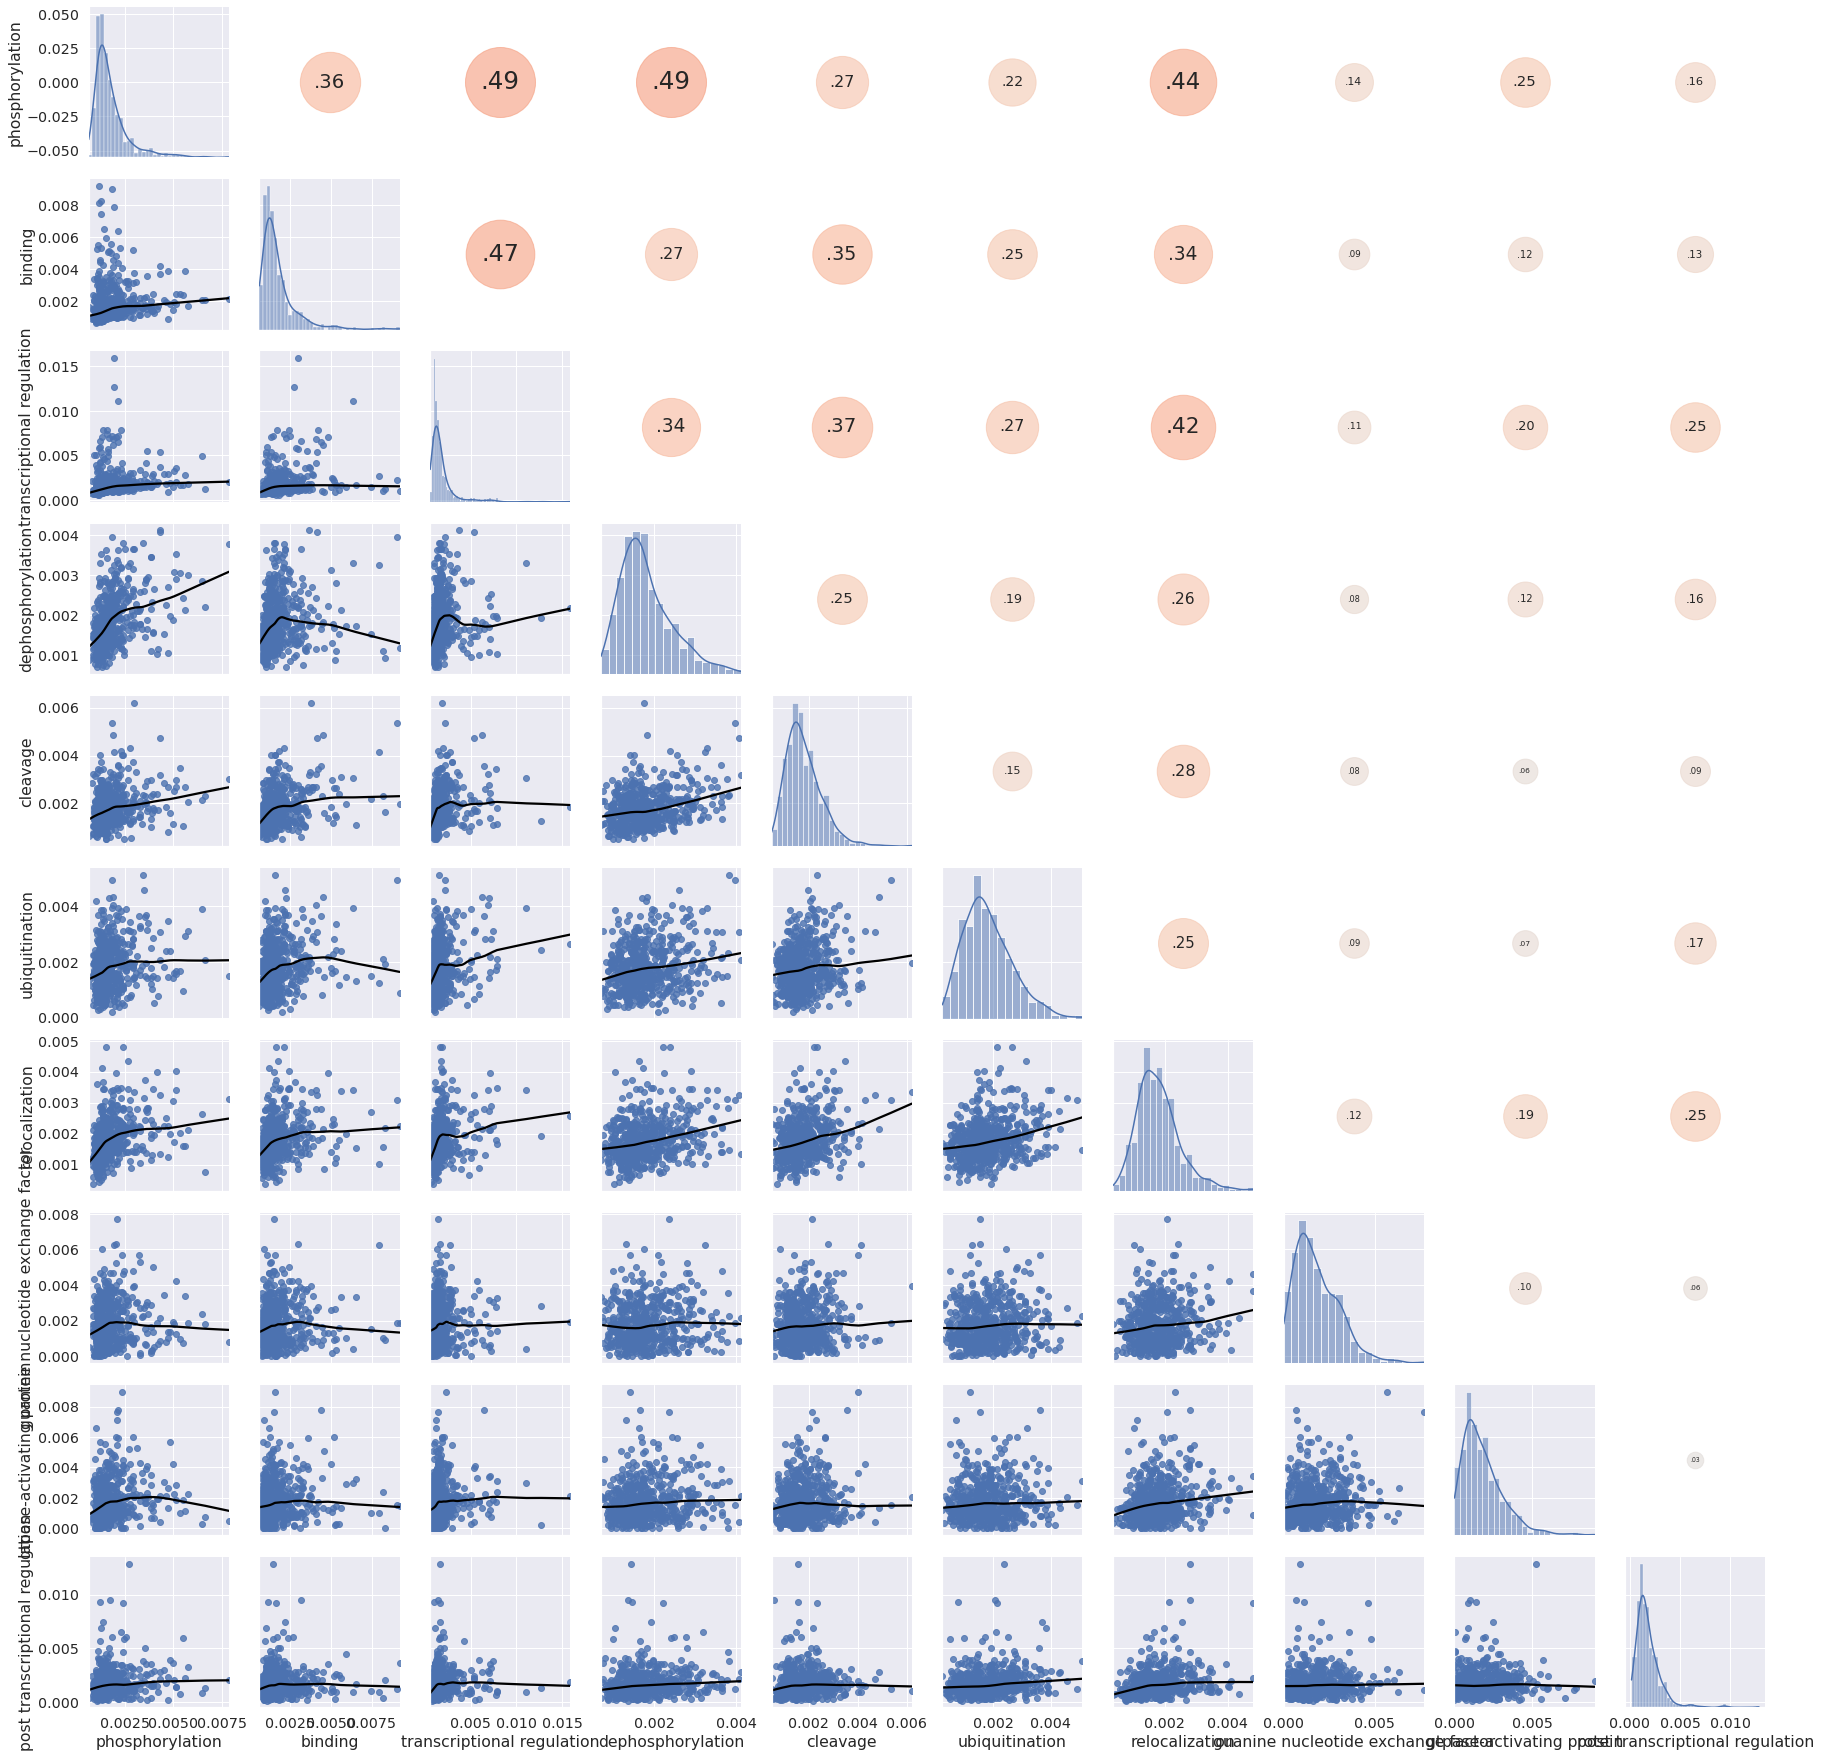

In [3]:
aai, ind = aaindex1('AGVWPY')

signor = pd.read_csv('../../ref/signor/Jan2022_release.txt.gz', sep='\t')
signor = signor[(signor.DATABASEA=='UNIPROT') & (signor.DATABASEB=='UNIPROT')].copy()
signor['Pairs'] = signor[['IDA','IDB']].values.tolist()
signor['Pairs'] = signor.Pairs.apply(lambda x: '_'.join(sorted(x)))

clfs = pd.read_pickle('../../clf/signor_clfs.pickle')

gini = []
for i in clfs:    
    importances = i.feature_importances_
    std = np.std([tree.feature_importances_ for tree in i.estimators_], axis=0)
    gi = pd.DataFrame(importances, index=ind)
    gi['std'] = std
    gi.reset_index(inplace=True)
    gi.columns = ['AAindex','Gini','Stdev']
    gini.append(gi)
    
for i,v in enumerate(signor.value_counts('MECHANISM').head(10).index):
    gini[i]['MECHANISM'] = v

gini = pd.concat(gini)
ginit = gini.pivot(index='MECHANISM', columns='AAindex', values='Gini').T
ginit = ginit[signor.value_counts('MECHANISM').head(10).index]


sns.set(font_scale=1.3)
g = sns.PairGrid(ginit, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde=True)
g.map_upper(corrdot)
plt.savefig('../../fig/signor_clfs_corrmatrix.pdf')